# Econ C142 Final Project
## Sahil Chinoy

## The returns to college major: A quantile regression approach

In [1]:
%matplotlib inline
import math
import scipy
import decimal
import numpy as np
import pandas as pd
from itertools import product
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data

I'm using data from the 2015 ACS, aggregated by IPUMS. Each observation is a single person, and we observe their wage, field of degree, race, sex, and age. I've already limited the sample to individuals age 23 and older who worked more than 40 weeks in 2014, to make sure yearly wages are comparable.

In [2]:
df = pd.read_csv('usa_00009.csv')

In [3]:
df.head()

,SEX,AGE,RACE,RACED,DEGFIELD,DEGFIELDD,WKSWORK2,INCWAGE
0,1,56,2,200,0,0,6,2800
1,1,53,1,100,19,1901,6,150000
2,2,53,1,100,0,0,4,6000
3,2,46,1,100,0,0,6,27000
4,1,53,1,100,0,0,6,10000


In [4]:
# Drop if no degree field or if no wage
df = df[(df['DEGFIELD'] != 0) & (df['INCWAGE'] > 0)]
# Compute log wage
df['LNWAGE'] = np.log(df['INCWAGE'])

Some housekeeping: we need to convert the sex, race, and degree field codes in the ACS to labeled values.

In [5]:
sex_map = {
    1: "M",
    2: "F"
}
df['SEX'] = df['SEX'].map(sex_map)

In [6]:
race_map = {
    1: "White",
    2: "Black/Negro",
    3: "American Indian or Alaska Native",
    4: "Chinese",
    5: "Japanese",
    6: "Other Asian or Pacific Islander",
    7: "Other race, nec",
    8: "Two major races",
    9: "Three or more major races"
}
df['RACE'] = df['RACE'].map(race_map)

In [7]:
degfield_map = {
    11: "Agriculture",
    13: "Environment and Natural Resources",
    14: "Architecture",
    15: "Area, Ethnic, and Civilization Studies",
    19: "Communications",
    20: "Communication Technologies",
    21: "Computer and Information Sciences",
    22: "Cosmetology Services and Culinary Arts",
    23: "Education Administration and Teaching",
    24: "Engineering",
    25: "Engineering Technologies",
    26: "Linguistics and Foreign Languages",
    29: "Family and Consumer Sciences",
    32: "Law",
    33: "English Language, Literature, and Composition",
    34: "Liberal Arts and Humanities",
    35: "Library Science",
    36: "Biology and Life Sciences",
    37: "Mathematics and Statistics",
    38: "Military Technologies",
    40: "Interdisciplinary and Multi-Disciplinary Studies (General)",
    41: "Physical Fitness, Parks, Recreation, and Leisure",
    48: "Philosophy and Religious Studies",
    49: "Theology and Religious Vocations",
    50: "Physical Sciences",
    51: "Nuclear, Industrial Radiology, and Biological Technologies",
    52: "Psychology",
    53: "Criminal Justice and Fire Protection",
    54: "Public Affairs, Policy, and Social Work",
    55: "Social Sciences",
    56: "Construction Services",
    57: "Electrical and Mechanic Repairs and Technologies",
    58: "Precision Production and Industrial Arts",
    59: "Transportation Sciences and Technologies",
    60: "Fine Arts",
    61: "Medical and Health Sciences and Services",
    62: "Business",
    64: "History"
}
df['DEGFIELD'] = df['DEGFIELD'].map(degfield_map)

Let's make sure each degree field is adequately represented in the sample. We don't want outliers to unduly influence our summary statistics and regression results when we group by degree field.

In [8]:
# Degree field by number of observations
counts = df[['DEGFIELD','SEX']].groupby('DEGFIELD') \
    .aggregate('count').rename(columns={'SEX':'count'})
# 10 degree fields with the fewest observations
counts.sort_values('count').head(n=10)

,count
DEGFIELD,
Military Technologies,38
Electrical and Mechanic Repairs and Technologies,131
"Nuclear, Industrial Radiology, and Biological Technologies",131
Library Science,138
Cosmetology Services and Culinary Arts,340
Communication Technologies,559
Law,648
Construction Services,862
Transportation Sciences and Technologies,1189


In [9]:
# Cut degree fields with fewer than 500 observations
exclude_fields = list(counts[counts['count'] < 500].index)
df = df[~df['DEGFIELD'].isin(exclude_fields)]

In [10]:
# Sample size
N = len(df)
print('Sample size: %d' % N)

Sample size: 381852


The final sample contains about 380,000 observations.

In [11]:
# These are the unique values of each categorical variable,
# which we will need later
sex_range = df['SEX'].unique()
race_range = df['RACE'].unique()
degfield_range = df['DEGFIELD'].unique()

## Summary statistics

In [12]:
# 10 degrees with highest average wage
avg = df[['DEGFIELD','INCWAGE']].groupby('DEGFIELD') \
    .mean().sort_values('INCWAGE', ascending=False).round(2)
avg.head(n=10)

,INCWAGE
DEGFIELD,
Engineering,111888.19
Biology and Life Sciences,104841.85
Physical Sciences,102970.25
Mathematics and Statistics,100254.41
Computer and Information Sciences,95371.24
Social Sciences,95007.78
Transportation Sciences and Technologies,91478.05
Business,89170.16
Construction Services,88169.26


Above are the ten degrees with the highest average wage. Engineering and math-related fields are near the top. Social Sciences makes it as well -- perhaps these are the lawyers and other white-collar professionals in the sample. Somewhat more surprisingly, Construction Services makes it, too. This could be due to the fact, for example, that many of the construction workers in this sample are older than average, and older workers get paid more, or that the field has far more men than women, and men get paid more. Effects like this are why we need to run a regression as opposed to merely presenting averages.

In [13]:
# 10 degrees with lowest average wage
avg.tail(n=10)

,INCWAGE
DEGFIELD,
Interdisciplinary and Multi-Disciplinary Studies (General),65311.32
Psychology,64891.02
Criminal Justice and Fire Protection,62744.77
Communication Technologies,59153.67
Fine Arts,57816.31
"Public Affairs, Policy, and Social Work",57492.19
"Physical Fitness, Parks, Recreation, and Leisure",57318.19
Education Administration and Teaching,54130.81
Family and Consumer Sciences,52532.09


Nothing too remarkable here -- these are largely vocational degrees that are unlikely to lead to high-paying, private-sector jobs or to further study. Psychology is particularly low-return for a social science degree.

In [14]:
# Crosstab of average wage by gender and degree field
ctab = pd.crosstab(
    index=df['DEGFIELD'],
    columns=df['SEX'],
    values=df['INCWAGE'],
    aggfunc=np.mean
).round(2)
ctab['gap'] = ctab['M'] - ctab['F']
ctab.sort_values('gap', ascending=False).head(n=10)

SEX,F,M,gap
DEGFIELD,,,
Biology and Life Sciences,80250.14,131089.66,50839.52
Social Sciences,71118.79,115645.19,44526.40
Law,60323.31,99913.38,39590.07
Physical Sciences,78073.79,117440.52,39366.73
Business,68970.09,106193.68,37223.59
Construction Services,56251.39,91078.23,34826.84
Medical and Health Sciences and Services,68499.75,103108.11,34608.36
History,65413.54,97434.48,32020.94
Mathematics and Statistics,81780.08,113362.21,31582.13


The field with the largest gender gap is Biology. Perhaps this reflects the fact that there are more male doctors and more female medical technicians, nurses or assistants. Across the board, however, the magnitude of the gender gap is pretty stunning -- a $50,000 difference in average salary is huge.

## OLS regression

Let's run an OLS regression to control for age, sex and race. This let us tease apart the effects of demographics from the "pure" effect of the degree field. Note that this does not control for occupation; this is because I consider the choice of one's career as part of the effect of choosing a particular degree field.

OLS estimates the average, or arithmetic mean, returns to each degree field. As the endogenous variable is log wage, we can think of the coefficient on each degree dummy as the average percent increase in wages one can expect if they choose that degree relative to the omitted category, Agriculture.

In [15]:
# Check omitted category
print(pd.get_dummies(df['DEGFIELD']).columns[0])

Agriculture


In [16]:
# Endogenous variable
y = df['LNWAGE']
# Exogenous variables
X = pd.DataFrame()
# Assume wages are quadratically dependent on age
X['AGE'] = df['AGE']
X['AGE_SQ'] = X['AGE']**2 
# Drop the first dummy to avoid multicollinearity...
X = X.join(pd.get_dummies(df['SEX'], drop_first=True))
X = X.join(pd.get_dummies(df['RACE'], drop_first=True))
X = X.join(pd.get_dummies(df['DEGFIELD'], drop_first=True))
# ...and explicitly add a constant term
X = sm.add_constant(X)
# Fit the model
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 LNWAGE   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2074.
Date:                Mon, 08 May 2017   Prob (F-statistic):               0.00
Time:                        17:16:16   Log-Likelihood:            -4.3020e+05
No. Observations:              381852   AIC:                         8.605e+05
Df Residuals:                  381809   BIC:                         8.609e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------

In [17]:
coeffs = pd.DataFrame(index = degfield_range[1:], columns=['OLS','OLS_se'])
for degfield in coeffs.index:
    coeffs.loc[degfield]['OLS'] = res.params.get(degfield)
    coeffs.loc[degfield]['OLS_se'] = res.bse.get(degfield)

In [18]:
coeffs.sort_values('OLS', ascending=False).head(n=10)

,OLS,OLS_se
Engineering,0.413468,0.0118992
Biology and Life Sciences,0.321222,0.0123522
Mathematics and Statistics,0.311265,0.0152839
Computer and Information Sciences,0.307416,0.0127046
Physical Sciences,0.28333,0.013209
Construction Services,0.249006,0.027762
Medical and Health Sciences and Services,0.245174,0.0119979
Social Sciences,0.227526,0.011979
Business,0.200394,0.0114112
Transportation Sciences and Technologies,0.184832,0.0243456


The highest-return fields, controlling for demographic characteristics, are largely the same as the simple list of mean wages, although the order is permuted. However, Medical Services enters in this list in place of Engineering Technologies. One hypothesis is that the population of those who study Military Technologies might be heavily skewed male, which would increase the field's average wage, and the population of those who study Medical Services is heavily skewed female. To check this, we compute the number of graduates by sex for each of these fields in the sample.

In [19]:
df[(df['DEGFIELD'] == 'Engineering Technologies') | \
   (df['DEGFIELD'] == 'Medical and Health Sciences and Services')] \
    [['DEGFIELD','SEX','AGE']].groupby(['DEGFIELD','SEX']) \
    .count().rename(columns={'AGE':'count'})

count
DEGFIELD                                 SEX       
Engineering Technologies                 F      518
                                         M     2634
Medical and Health Sciences and Services F    24114
                                         M     5204

The hypothesis seems to be true. So, Military Technologies isn't actually a great degree to pursue if you're interested in future earnings (and not male), and Medical Services might be better.

## Quantile regression

Now, we run the same regression, except instead of estimating the mean returns to field of degree, we will estimate returns at quantiles ranging from the 5th percentile to the 95th percentile. This is motivated by the idea that perhaps most Business graduates only earn moderate wages, except those that go on to become CEOs -- the mean returns will then be very different from the returns at the highest quantiles.

In [20]:
# Here are the quantiles we will compute:
# 5th percentile to the 95th percentile, by fives
quantiles = np.arange(0.05, 1, 0.05)
# Bin observations by age: we choose
# bins of size 5, starting with age 23
age_range = list(np.arange(23, 58, 5))

In [21]:
def quantile_estimate(data, tau):
    """
    Takes a Series data and a quantile tau and
    returns (pi, s2, se), where
    - pi is an estimate of the quantile
    - s2 is an estimate of the variance,
    - se is an estimate of the standard error.
    """
    try:
        # Sort the data
        data = sorted(data)
        n = len(data)
        # Estimate of the quantile
        pi = np.percentile(data, q=tau*100)
        # z-value for a 95% confidence interval
        z = scipy.stats.norm.ppf(0.975)
        l = z*math.sqrt(n*tau*(1-tau))
        # Index of lower bound
        j = math.floor(n*tau - l)
        # Lower bound of CI
        lbound = data[j-1]
        # Index of upper bound
        k = math.ceil(n*tau + l)
        # Upper bound of CI
        ubound = data[k-1]
        # Variance estimator
        s2 = n*(ubound-lbound)**2/(4*z**2)    
        # Standard error estimator
        se = math.sqrt(s2/n)
        return pi, s2, se
    except:
        # This happens if the index of the lower/
        # upper bound, j or k, is outside the range
        # of the data. In this case, just drop
        # this cell
        return None, None, None

In [22]:
# We'll store our estimates here
estimates = pd.DataFrame(columns=[
    'age',
    'sex',
    'race',
    'degfield',
    'n', # number of observations in this bin
    'tau', # quantile of interest
    'pi', # quantile estimate
    's2', # variance estimate
    'se' # standard error estimate
])

# Iterate through the Cartesian product of the bins
for combination in product(age_range, sex_range, race_range, degfield_range):
    age, sex, race, degfield = combination
    # Get the right data
    subset = df[(df['AGE'] >= age) & (df['AGE'] < (age + 5)) \
             & (df['SEX'] == sex) & (df['RACE'] == race) \
             & (df['DEGFIELD'] == degfield)]
    earnings = subset['LNWAGE']
    n = len(earnings)
    # Minimum number of observations in each bin
    if n < 50:
        continue
    # Estimate each quantile and standard error
    for quantile in quantiles:
        pi, s2, se = quantile_estimate(earnings, quantile)
        # Drop bad bins
        if not pi:
            continue
        estimates = estimates.append({
            'age': age,
            'sex': sex,
            'race': race,
            'degfield': degfield,
            'tau': quantile,
            'n': n,
            'pi': pi,
            's2': s2,
            'se': se
        }, ignore_index=True)

In [23]:
# Drop if variance estimate is 0
print(len(estimates))
estimates = estimates[estimates['s2'] > 0]
print(len(estimates))

14407
14362


We're dropping about 50 cells because the variance estimate is zero -- we have a series of values with the exact same earnings, thus we can't get an estimate of the variance using the method outlined in Chamberlain (1994).

Now, we regress the estimates for each cell for each quantile separately. The standard errors of our coefficients are given by $se(\alpha) = \sqrt{\text{diag}[(X^{T}\Omega X)^{-1}/N]}$, while the standard errors reported by the WLS program are $se^*(\alpha) = \sqrt{s^2 \cdot \text{diag}[(X^{T}\Omega X)^{-1}]}$, where $s^2$ is the standard error of the regression, $\Omega$ is the matrix of weights, and $N$ is the total number of observations. So, we correct the standard error reported by the WLS program, $se^*(\alpha)$, with the following:

$$se(\alpha) = \frac{se^*(\alpha)}{\sqrt{s^2 \cdot N}}.$$

In [24]:
def quantile_regress(data):
    """
    Takes a DataFrame data and returns a DataFrame
    of coefficients and standard errors for each
    degree field.
    """
    # Endogenous variable
    y = data['pi']
    # Exogenous variables
    X = pd.DataFrame()
    # Midpoint of the age range
    X['age'] = data['age'] + 2.5
    # Age squared
    X['age_sq'] = X['age']**2
    X = X.join(pd.get_dummies(data['sex'], drop_first=True))
    X = X.join(pd.get_dummies(data['race'], drop_first=True))
    X = X.join(pd.get_dummies(data['degfield'], drop_first=True))
    X = sm.add_constant(X)
    # WLS weights
    weights = data['n']/(N * data['s2'])
    # Fit the model
    res = sm.WLS(y, X, weights).fit()
    # Correct the standard errors
    res.bse = res.bse / math.sqrt(res.mse_resid * N)
    
    # Construct a DataFrame to store the coefficients on each
    # degree field
    q_coeffs = pd.DataFrame(
        index = degfield_range[1:],
        columns=['q','q_se'])
    for degfield in q_coeffs.index:
        q_coeffs.loc[degfield]['q'] = res.params.get(degfield)
        q_coeffs.loc[degfield]['q_se'] = res.bse.get(degfield)
    
    return q_coeffs

In [25]:
# Run the regression for each quantile
for quantile in quantiles:
    data = estimates[estimates['tau'] == quantile]
    q_coeffs = quantile_regress(data)
    q_coeffs.columns = [
        'q{0:0.02f}'.format(quantile),
        'q{0:0.02f}_se'.format(quantile)]
    coeffs = coeffs.join(q_coeffs)

In [26]:
coeffs = coeffs.dropna()

In [27]:
# 10 highest return majors at the 5th percentile of earnings
coeffs[['q0.05','q0.05_se']].sort_values('q0.05', ascending=False).head(n=10)

,q0.05,q0.05_se
Construction Services,0.498209,0.197698
Engineering,0.441625,0.0510474
Medical and Health Sciences and Services,0.396582,0.0514951
Computer and Information Sciences,0.335502,0.0545972
Engineering Technologies,0.328475,0.0707237
Mathematics and Statistics,0.318259,0.0681758
Physical Sciences,0.273612,0.0541946
Environment and Natural Resources,0.272756,0.0698255
Transportation Sciences and Technologies,0.252474,0.158349
Business,0.227329,0.0489841


In [28]:
# 10 highest return majors at the 95th percentile of earnings
coeffs[['q0.95','q0.95_se']].sort_values('q0.95', ascending=False).head(n=10)

,q0.95,q0.95_se
Biology and Life Sciences,0.608747,0.0273452
Social Sciences,0.484631,0.0276436
Physical Sciences,0.468696,0.028579
Mathematics and Statistics,0.391239,0.0364577
Business,0.303022,0.026912
Engineering,0.293879,0.0277633
History,0.273194,0.0340981
"Area, Ethnic, and Civilization Studies",0.183354,0.104819
Linguistics and Foreign Languages,0.142257,0.0462283
"English Language, Literature, and Composition",0.13618,0.0300093


Now, this is interesting. The ranking is fairly different between the 5th percentile and the 95th percentile of earners. In particular, Construction Services is the highest-return major for low earners, but doesn't even make the top ten for the high earners. Likewise, Biology is the highest-return major for high earners, but doesn't make the list for low earners. This makes sense: construction work is relatively well-paying among blue-collar jobs, while doctors earn high wages even among high earners.

Unexpectedly, Computer Science doesn't make the list of high-return majors at the 95th percentile. Computer Science might be a good middle-class or upper-middle class major, then, but isn't as common among the super-rich. It's a conservative major choice.

I'm also interested in how Linguistics and English Language made the list at the 95th percentile. I suspect this is a group of students who go on to pursue higher degrees; an extension of this analysis could be be to control for highest degree earned in the regression.

To get a better sense of the returns to each major, we plot the quantile regression coefficient versus the quantile, by degree field.

In [29]:
# Sort by median returns
coeffs = coeffs.sort_values('q0.50', ascending=False)

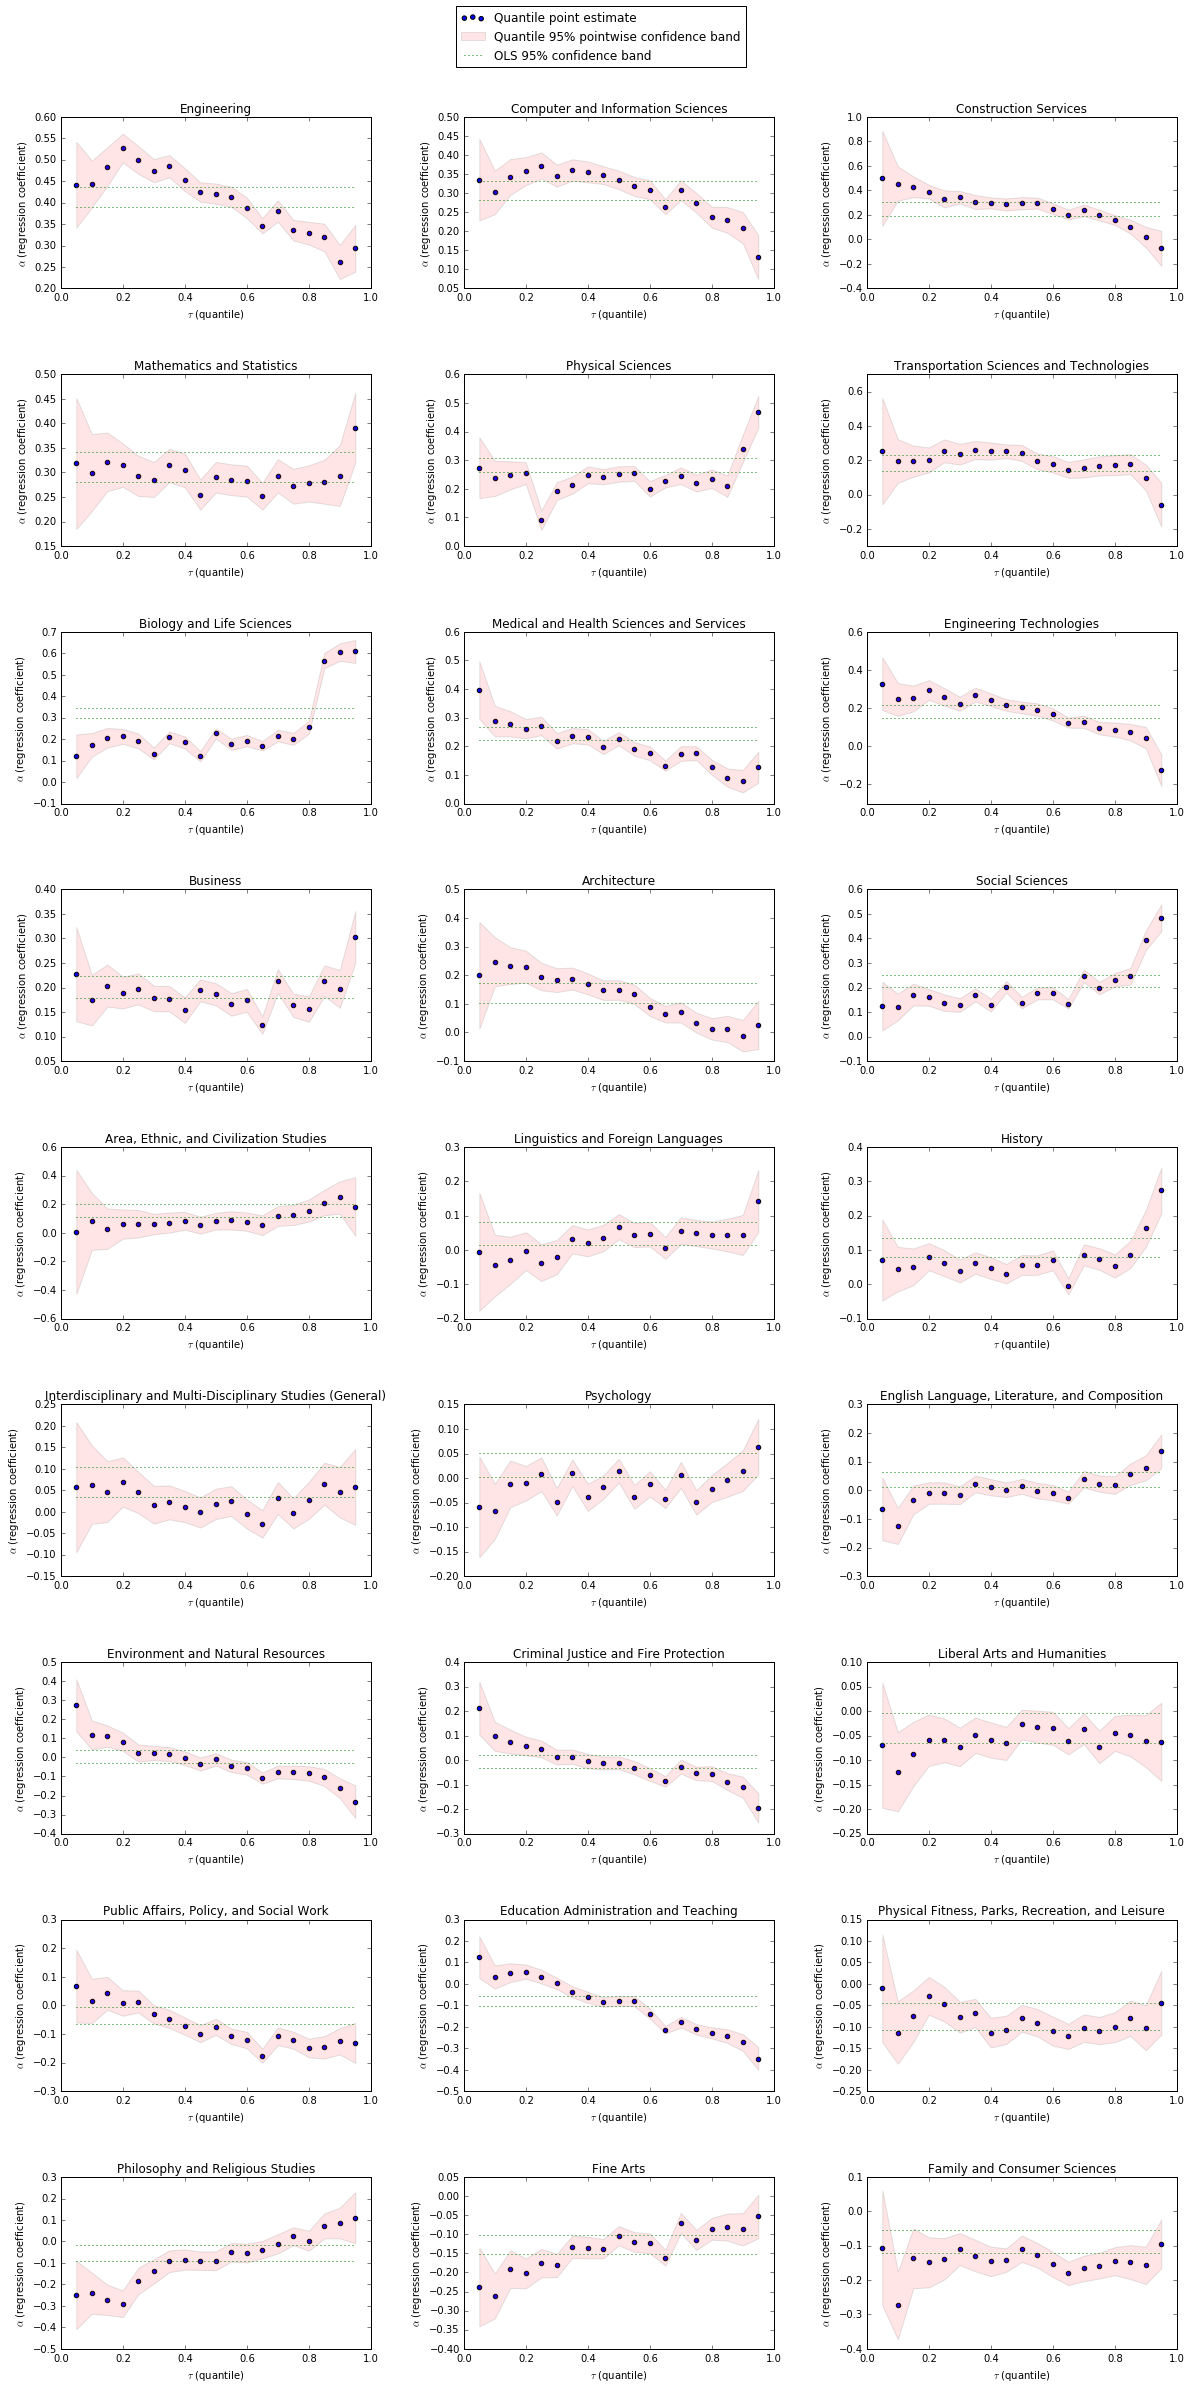

In [30]:
fig, axs = plt.subplots((len(coeffs.index) // 3), 3, figsize=(20,40))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for ax, degfield in zip(axs.ravel(), coeffs.index):
    ax.set_title(degfield)
    ax.set_xlim([0,1])
    ax.set_xlabel(r'$\tau$ (quantile)')
    ax.set_ylabel(r'$\alpha$ (regression coefficient)')
    # Parameter point estimates for quantiles
    y = list(coeffs.loc[degfield][['q{0:0.02f}'.format(quantile) \
            for quantile in quantiles]])
    sc = ax.scatter(quantiles, y)
    # Standard errors for quantile estimates
    se = coeffs.loc[degfield][['q{0:0.02f}_se'.format(quantile) \
            for quantile in quantiles]]
    # z-value for a 95% confidence interval
    z = scipy.stats.norm.ppf(0.975)
    # CI lower and upper bounds
    lower = list(y - z*se)
    upper = list(y + z*se)
    # Plot confidence band
    ci = ax.fill_between(
        quantiles,
        lower,
        upper,
        facecolor='red',
        alpha=0.1
    )
    # 95% CI for OLS estimate
    y2 = list(coeffs.loc[degfield][['OLS'.format(quantile) \
            for quantile in quantiles]])
    se2 = coeffs.loc[degfield][['OLS_se'.format(quantile) \
            for quantile in quantiles]]
    lower2 = list(y2 - z*se2)
    upper2 = list(y2 + z*se2)
    # http://stackoverflow.com/questions/11983024/matplotlib-legends-not-working
    ci2, = ax.plot(quantiles, upper2, '-', color='g', ls='dotted')
    ax.plot(quantiles, lower2, '-', color='g', ls='dotted')

leg = plt.figlegend(
    (sc, ci, ci2),
    ('Quantile point estimate',
     'Quantile 95% pointwise confidence band',
     'OLS 95% confidence band'),
    loc = 'upper center')

# http://stackoverflow.com/questions/23238041/move-and-resize-legends-box-in-matplotlib
plt.draw() # Draw the figure to find the position of the legend
# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change the location of the legend
yOffset = -1
bb.y0 += yOffset
bb.y1 += yOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

There are many interesting points to be made here, but here are a few key findings:
* There are some majors whose returns pick up dramatically at the upper end of the earnings distribution, namely Biology, Social Sciences, Physical Sciences, and History. This probably reflects the fact that there are mostly relatively low-paying jobs available to those majors whose terminal degree is a bachelor's, but some students pursue further education and end up as well-paid professionals. We can imagine this being particularly true for Biology students -- the wage differential between a lab assistant and a surgeon is huge.
* Business picks up at the 95th percentile: it's a relatively common major and is thus not unusually well-paying across most of the distribution, but there are likely a group of highly-paid executives that make business high-return at the upper end of the distribution.
* There are a few majors whose returns consistently decline as we move up the earnings distribution, namely Education, Medical Services, Engineering, Computer Science and Architecture. It's not completely clear what's going on here, but one hypothesis is that these fields lead to well-paying jobs, but limited room for advancement. In other words, you're likely to make a good salary for most of your life, but unlikely to get rich.
* Construction Services is one of the highest-return majors at the low quantiles, but has *negative* returns (in other words, lower returns than Agriculture) at the highest quantiles.
* The best Fine Arts graduates are doing okay, but across most of the earnings distribution, the major has negative returns compared to Agriculture.
* In general, the quantile estimates across much of the earnings distribution lie outside the OLS confidence band. This means that estimating the effect on average wages, as OLS does, does not tell the whole story.

An important consideration is that at *each* quantile, coefficients are estimated relative to the omitted category, Agriculture. Thus, we assume the line for Agriculture is relatively flat across quantiles, otherwise all of the other lines will be tilted accordingly. There is no good way of gauging which major to pick as the omitted category besides avoiding fields like Business, which we expect to have very different returns at different quantiles.

In my opinion, the primary limitation of this analysis is that it doesn't control for degrees beyond a bachelor's. In other words, it could be the case that the 95th percentile of English majors are people who go on to law school and become wealthy. You could consider this part of the effect of earning an English degree, but it's also interesting to examine *just* the effect of the bachelor's degree field of study, controlling for higher degrees earned. It wouldn't be complicated to incorporate this -- the ACS has this field -- but with this quantile regression approach, at some point, the cell sizes will become too small. Also, these major codes are relatively coarse; Economics, for example, is absorbed in Social Sciences. The ACS has more specific major information (Chemistry as opposed to "Physical Sciences"), but again, we need to maintain sufficient cell size to estimate the quantiles (especially the extreme quantiles) with enough precision. If we aggregate data across multiple years of the ACS and use inflation-adjusted wages, and make the assumption that the returns to each major haven't changed dramatically over time, then we would likely have enough data to estimate these coefficients for the disaggregated major codes. These are promising areas for future work.